<a href="https://colab.research.google.com/github/SampadSikder/DP-Protocols/blob/main/AttackVBenign_ExploratoryDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Parameter Loading

In [1]:
import argparse
import math
import matplotlib.pyplot as plt

In [2]:
import random
from multiprocessing import Pool
import numpy as np
import xxhash
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass
from typing import Literal, Dict, Any, List
from scipy.special import erfcinv

from tqdm import tqdm
import seaborn as sns

In [3]:
domain = 0
epsilon = 0.0
n = 0
g = 0
X = []
Y = []
Y_Nattack = []
sample = []
REAL_DIST = []
ESTIMATE_DIST = []
User_Seed = []
User_Seed_Nattack = []
p = 0.0
q = 0.0
Gain = 0
splits = 0
h_ao = 0
global Gain, ESTIMATE_DIST, Y

In [4]:
#from google.colab import drive
#|drive.mount('/content/drive')

In [5]:
global ESTIMATE_DIST, REAL_DIST, n, p, q, epsilon, domain, User_Seed, User_Seed_Nattack, target_set_size, vswhat, g, splits, h_ao

In [6]:
epsilon = 0.7
splits = 6
h_ao = 1 # for adaptive attack
g = int(round(math.exp(epsilon))) + 1
dataset = 'zipf'
ratio = 0.4
target_set_size = 20

In [7]:
if dataset == 'zipf':
        #n = 100000
        n = 30000
        domain = 1024
if dataset == 'emoji':
        #n = 218477
        n = 70000
        domain = 1496
if dataset == 'fire':
        #n = 723090
        n = 30000
        domain = 296

In [8]:
User_Seed = np.zeros(n)
User_Seed_Nattack = np.zeros(n)
REAL_DIST = np.zeros(domain)
#REAL_DIST = Counter()
ESTIMATE_DIST = np.zeros(domain)

In [9]:
p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
q = 1.0 / (math.exp(epsilon) + g - 1)

print('n: ', n)
print('ratio: ', ratio)
print('target_set_size: ', target_set_size)
print('e: ', epsilon)
print('split: ', splits)
print('h_ao: ', h_ao)

n:  30000
ratio:  0.4
target_set_size:  20
e:  0.7
split:  6
h_ao:  1


## Load Dataset

In [52]:
def generate_zipf_dist():
  global REAL_DIST, domain, sample, X
  X = np.load('/content/drive/MyDrive/Purdue Work/Datasets/zipf.npy')
  for i in range(n):
    REAL_DIST[X[i]] += 1



In [53]:
def generate_emoji_dist():
  global X
  data = np.load('/content/drive/MyDrive/Purdue Work/Datasets/emoji.npy')
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [54]:
def generate_fire_dist():
  global X
  values = pd.read_csv("/content/drive/MyDrive/Purdue Work/Datasets/fire.csv")["Unit_ID"]
  #print(np.array(values))
  lf = LabelEncoder().fit(values)
  data = lf.transform(values)
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [55]:
## Local Loading
def generate_zipf_dist():
  global REAL_DIST, domain, sample, X
  X = np.load('./zipf.npy')
  for i in range(n):
    REAL_DIST[X[i]] += 1

def generate_emoji_dist():
  global X
  data = np.load('./emoji.npy')
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

def generate_fire_dist():
  global X
  values = pd.read_csv(".fire.csv")["Unit_ID"]
  #print(np.array(values))
  lf = LabelEncoder().fit(values)
  data = lf.transform(values)
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1


In [56]:
if dataset == 'zipf':
    generate_zipf_dist()
if dataset == 'emoji':
    generate_emoji_dist()
if dataset == 'fire':
    generate_fire_dist()

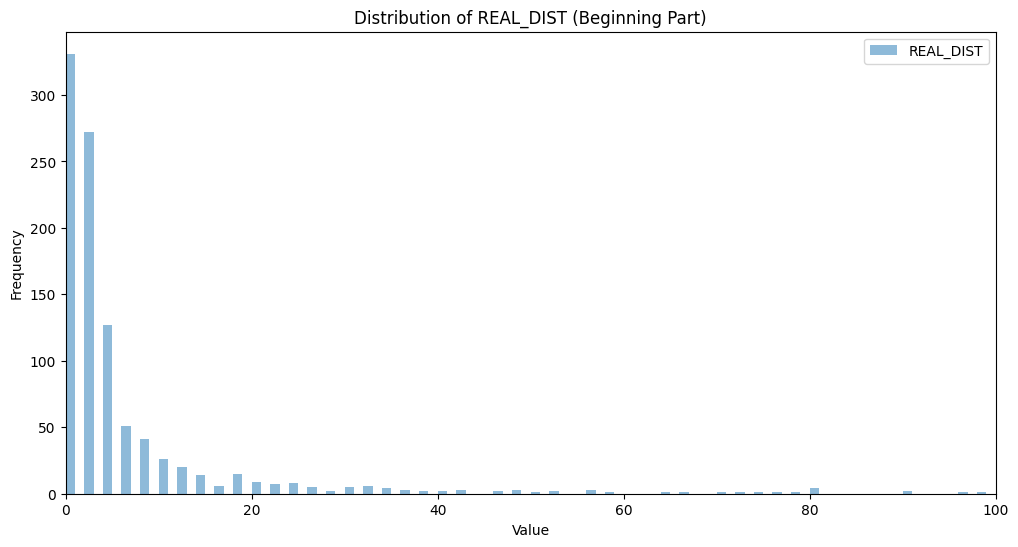

In [57]:
plt.figure(figsize=(12, 6))
plt.hist(REAL_DIST, bins=range(101), alpha=0.5, label='REAL_DIST')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of REAL_DIST (Beginning Part)')
plt.legend()
plt.xlim(0, 100)
plt.show()

## Protocols

In [58]:
from tqdm import tqdm
import random
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
from functools import partial
from multiprocessing import Pool
import math
import scipy.stats as stats
from scipy.stats import binom, chisquare


In [59]:
# APA Attack
def construct_omega(e, d, perturb_method):
    p_binomial = None
    if perturb_method == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(e) + 1)
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / g
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_binomial = 1 / 2
        p = q = 1 / 2
        expected_ones = d * p_binomial
    k_values = [i for i in range(d)]
    theoretical_pdf = binom.pmf(k_values, d, p_binomial)
    theoretical_pdf /= theoretical_pdf.sum()
    return theoretical_pdf

In [60]:
# Example of theoretical pdf from construct_omega
example_pdf = construct_omega(epsilon, domain, 'OLH_User')

print(f'Example of theoretical PDF from construct_omega (first 10 values):')
print(example_pdf[:10])
print(f'Length of the PDF: {len(example_pdf)}')

Example of theoretical PDF from construct_omega (first 10 values):
[3.73979269e-181 1.91619104e-178 4.90428573e-176 8.35981617e-174
 1.06771120e-171 1.08987148e-169 9.26167512e-168 6.73954538e-166
 4.28699413e-164 2.42156097e-162]
Length of the PDF: 1024


In [61]:
def perturb_ideal(target_set = None, ratio = 0, e = 0):
    global Y, Gain, User_Seed
    Y = np.zeros(n)
    #random.shuffle(X)
    for i in range(n):
        if i < n * (1 - ratio):
            v = X[i]
            # intdigest -> get integer value from xxhash(Output of xxhash is a hash item)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()

            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
        else:
            projection_total = len(target_set)
            max_seed = i
            v = random.choice(target_set)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()
            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
    return User_Seed

# Estimates

## Default Estimates

In [62]:
def z_bonferroni(delta_over_d: float) -> float:
    return float((2.0 ** 0.5) * erfcinv(2.0 * delta_over_d))

In [63]:
Mechanism = Literal["OUE", "OLH", "HST_User", "HST_Server"]

def construct_omega(e: float, d: int, perturb_method: str) -> np.ndarray:
    if perturb_method == 'OUE':
        p = 1/2
        q = 1/(math.exp(e) + 1)
        p_bin = (1/d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server', 'OLH'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / (math.exp(e) + g - 1)
        p_bin = (1/d) * (p + (d - 1) * q)
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_bin = 1/2
    else:
        raise ValueError("Unknown perturb_method")
    k = np.arange(d)
    pdf = binom.pmf(k, d, p_bin)
    pdf /= pdf.sum()
    return pdf

def _oq_params_oue(epsilon: float):
    p = 0.5
    q = 1 / (math.exp(epsilon) + 1)
    return p, q

def _olh_params(epsilon: float, n: int):
    g = int(round(math.exp(epsilon))) + 1
    denom = math.exp(epsilon) + g - 1
    p = math.exp(epsilon) / denom
    q = 1.0 / denom
    denom_pg = (p * g - 1.0)
    if abs(denom_pg) < 1e-12:
        a = float('inf')
        b_n = float('inf')
    else:
        a = g / denom_pg
        b_n = n / denom_pg
    return g, p, q, a, b_n

In [64]:
def build_normal_lists_from_mechanism_stochastic(
    epsilon: float, d: int, n: int, mechanism: str = "OUE", seed: int = 0
):
    rng = np.random.default_rng(seed)

    if mechanism == "OUE":
        omega = construct_omega(epsilon, d, 'OUE')
        p, q = 0.5, 1.0 / (math.exp(epsilon) + 1.0)

    elif mechanism == "OLH":
        omega = construct_omega(epsilon, d, 'OLH')
        g, p_olh, q_olh, a, b_n = _olh_params(epsilon, n)

    elif mechanism in ("HST_User", "HST_Server"):
        omega = construct_omega(epsilon, d, mechanism)

    else:
        raise ValueError("mechanism must be 'OUE', 'OLH', 'HST_User', or 'HST_Server'.")

    k_values = np.arange(d)
    K = rng.choice(k_values, size=n, p=omega)

    support = np.zeros((n, d), dtype=int)
    for i, k in enumerate(K):
        if k > 0:
            idx = rng.choice(d, size=min(k, d), replace=False)
            support[i, idx] = 1

    one_list = support.sum(axis=1)
    obs_counts = support.sum(axis=0).astype(float)

    if mechanism == "OUE":
        normal_ESTIMATE_DIST = (obs_counts - n * q) / max(p - q, 1e-12)
    elif mechanism == "OLH":
        normal_ESTIMATE_DIST = a * obs_counts - b_n
    else:
        normal_ESTIMATE_DIST = obs_counts

    normal_ESTIMATE_Input = None
    return support, one_list, normal_ESTIMATE_DIST, normal_ESTIMATE_Input

## OLH

### Attacked OLH

In [65]:
num_samples = 1000000


In [66]:
def uniform_sampling_best_vector(target_set, g, d, m, num_samples):
    best_vector = None
    closest_ones_diff = float('inf')
    max_target_count = 0
    best_score = -float('inf')
    current_target = None
    current_diff = None

    for _ in range(num_samples):
        # Generate uniform samples for binary vectors (0 or 1)
        vector = np.random.binomial(1, 1 / g, size=d)

        # Count the number of 1's in the vector
        ones_count = np.sum(vector)
        ones_diff = abs(ones_count - m)  # Difference between current 1's count and target m

        # Count how many target items map to positions with 1's in the vector
        target_count = sum(1 for item in target_set if vector[item % d] == 1)

        # Calculate the score: target_count - ones_diff
        score = target_count - ones_diff

        # Update the best vector if the score is better
        if score > best_score:
            best_score = score
            best_vector = vector
            current_target = target_count
            current_diff = ones_diff

    return best_vector, current_target, current_diff

In [67]:
def calculate_prob_according_sample_size(num_samples, d, g, h, target_set, splits):

    splits_list = random.sample(list(target_set), splits)
    target_set = splits_list
    user_vectors = []
    p = 1 / g

    mu = d * p
    sigma = np.sqrt(d * p * (1 - p))

    lower_bound = max(0, mu - h)
    upper_bound = min(d, mu + h)

    binom_dist = stats.binom(d, p)
    ratio = (binom_dist.cdf(upper_bound) - binom_dist.cdf(lower_bound - 1))
    ratio = ratio / (2 * h + 1)
    # ratio = 1

    N_effective = num_samples * ratio
    print('N_effective: ', N_effective)

    K_min = 1
    K_max = len(target_set)
    for K in range(K_max, K_min - 1, -1):
        prob = (p) ** K * N_effective
        if prob < 1:
            K_max = K
        else:
            break
    K_min = max(K_max, 1)

    K_values = np.arange(K_min, len(target_set) + 1)
    K_probs = []
    for K in K_values:
        prob = (p) ** K * N_effective
        K_probs.append(prob)
    K_probs = np.array(K_probs)

    K_probs = K_probs / np.sum(K_probs)

    return K_values, K_probs

In [68]:
def process_attacker(i, n, ratio, target_set, g, domain, splits, h_ao, e, K_values, K_probs):
    # Seed the random number generator uniquely for each process
    k = np.random.choice(K_values, p=K_probs)
    random.seed()
    averge_project_hash = int(domain / g)
    if splits < averge_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = averge_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        #h_ao = 0
        if h_ao == 0:
          num_map_AO = random.randint(num_map - int(h_ao), num_map + int(h_ao))
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        else:
          omega_probs = construct_omega(e, domain, 'OLH_User')
          num_map_AO = np.random.choice(range(domain), p=omega_probs)
        non_target_ones = num_map_AO - k
        # Each attacker finds their optimal hash function
        '''best_vector, target_map, diff  = uniform_sampling_best_vector(
            splits_list, g, domain, num_map_AO, num_samples)'''
        target_indices = np.random.choice(list(splits_list), size=k, replace=False)
        non_target_indices = list(set(range(domain)) - set(splits_list))
        non_target_selected = np.random.choice(non_target_indices, size=non_target_ones, replace=False)
        vector = np.zeros(domain, dtype=int)
        vector[target_indices] = 1
        vector[non_target_selected] = 1
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    #print(f'attacker:{i}, target_map:{k}, diff:{num_map_AO - sum(vector)}, h_ao:{h_ao}, splits:{splits}')
    return index, vector

In [69]:
def process_user_seeds(i, User_Seed_noattack, Y_Nattack, domain, g):
    print("Processing index" + str(i))
    local_estimate = np.zeros(domain)
    user_seed = User_Seed_noattack[i]
    for v in range(domain):
        if Y_Nattack[i] == (xxhash.xxh3_64(str(v), seed=int(user_seed)).intdigest() % g):
            local_estimate[v] += 1
    # Apply the correction factor
    local_estimate = local_estimate
    return local_estimate

In [70]:
def find_hash_function(seed_list, target_set, domain_eliminate, g, num_map_AO):
    # log the max projection number
    best_score = -np.inf
    # log the best projection seed
    best_seed = -1
    # log the target mapped
    best_target_mapped = None
    # log the best hash value
    best_hash_value = None
    # log the min gap
    best_gap = None
    for seed in seed_list:
        hash_projection_list = np.zeros(g)
        hash_other_projection_list = np.zeros(g)
        hash_result = None
        for item in target_set:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_projection_list[hash_result] += 1
        for item in domain_eliminate:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_other_projection_list[hash_result] += 1
        score = hash_projection_list - np.abs(num_map_AO - hash_projection_list - hash_other_projection_list)
        current_best_score = np.max(score)
        max_indices = np.where(score == current_best_score)[0]
        current_max_target_mapped = hash_projection_list[max_indices]
        current_untarget_mapped = hash_other_projection_list[max_indices]
        current_hash_value = max_indices
        current_gap = np.abs(num_map_AO - current_max_target_mapped - current_untarget_mapped)
        if current_best_score > best_score:
            best_seed = seed
            best_score = current_best_score
            best_hash_value = current_hash_value
            best_gap = current_gap
            best_target_mapped = current_max_target_mapped
    if best_seed == -1:
        return -1, 0.0, None
    return best_seed, best_gap, best_target_mapped, best_hash_value


In [71]:
def process_attacker_User(i, n, ratio, target_set, g, domain, splits, e, h_ao):
    average_project_hash = int(domain / g)
    vector = np.zeros(domain, dtype=int)
    if splits < average_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = average_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        num_map_AO = random.randint(num_map - h_ao, num_map + h_ao)
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        #num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        seed_list = random.sample(range(1, 10000000), num_samples)
        best_seed, best_gap, current_max_target_mapped, best_hash_value = find_hash_function(seed_list, splits_list,
                                                                                             remaining_set, g,
                                                                                             num_map_AO)
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    for v in range(domain):
        hashed_value = xxhash.xxh3_64(str(v), seed=int(best_seed)).intdigest() % g
        if hashed_value == best_hash_value:
            vector[v] = 1
   # print(f'attacker:{i}, target_map:{current_max_target_mapped}, diff:{best_gap}, h_ao:{h_ao}, splits:{splits}')
    return index, vector


In [72]:

def build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, e, h_ao=0, processor=100):

    K_values, K_probs = calculate_prob_according_sample_size(num_samples, domain, g, h_ao, target_set, splits)

    # Prepare the partial function with fixed arguments for multiprocessing
    process_attacker_partial = partial(
        #process_attacker_User,
        # Simulate 1,000,000 hash samples, fast version
        process_attacker,
        n=n,
        ratio=ratio,
        target_set=target_set,
        g=g,
        domain=domain,
        splits=splits,
        h_ao= 10*h_ao,
        e=e,
        K_values = K_values,
        K_probs = K_probs
    )

    # Calculate the number of attackers
    num_attackers = int(round(n * ratio))

    # Parallel execution of process_attacker using multiprocessing
    with Pool(processes=processor) as pool:
        # Use imap to process in parallel and tqdm for progress bar
        results = list(tqdm(
            pool.imap(process_attacker_partial, range(num_attackers)),
            total=num_attackers,
            desc='Finding optimal seeds'
        ))

    vector_matrix = np.zeros((num_attackers, domain))
    # Update User_Seed with the results from all attackers
    for i, (index, best_vector) in enumerate(results):
        vector_matrix[i, :] = best_vector

    # Create a partial function with fixed arguments for processing user seeds
    process_partial = partial(
        process_user_seeds,
        User_Seed_noattack=User_Seed,
        Y_Nattack=Y,
        domain=domain,
        g=g
    )

    # Process user seeds across multiple processes
    with Pool(processes=processor) as pool:
        estimates = pool.map(process_partial, range(n - num_attackers))
    # input attack's estimate
    '''with Pool(processes=processor) as pool:
        estimates_input = pool.map(process_partial, range(int(n)))'''

    # Combine the results from all processes
    estimates = np.array(estimates)
    # estimates_input = np.array(estimates_input)
    # estimates_input = estimates_input.reshape(int(n), domain)
    estimates = np.vstack((estimates, vector_matrix))
    estimates = estimates.reshape(int(n), domain)
    Results_support = estimates
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = np.sum(Results_support, axis=0)
    # Estimations_input = np.sum(estimates_input, axis=0)
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations = a * Estimations - b
    # Estimations_input = a * Estimations_input - b
    Estimations_input = None
    return Results_support, Results_support_one_list, Estimations, Estimations_input

### Normal OLH

In [73]:
def perturb_normal_olh(X, g, p, q):

    Y_normal = np.zeros(len(X))
    for i, v in enumerate(X):
        # Generate hash value
        x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
        y = x
        p_sample = np.random.random_sample()

        # Apply perturbation
        if p_sample <= p:

            # perturb
            y = np.random.randint(0, g)
        Y_normal[i] = y
    return Y_normal

In [74]:
def build_support_list_normal_olh(Y_normal, n, domain, g, p):
    Results_support_normal = np.zeros((n, domain))
    Estimations_normal_raw = np.zeros(domain)

    for i in range(n):
        user_seed = i  # Use the same seed as in perturbation
        for v in range(domain):
            hashed_value = (xxhash.xxh3_64(str(v), seed=user_seed).intdigest() % g)
            if Y_normal[i] == hashed_value:
                Results_support_normal[i, v] += 1
                Estimations_normal_raw[v] += 1

    Results_support_one_list_normal = np.sum(Results_support_normal, axis=1)

    # Apply the OLH correction factor
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations_normal = a * Estimations_normal_raw - b

    return Results_support_normal, Results_support_one_list_normal, Estimations_normal

## OUE

### Normal OUE

In [75]:
def perturb_normal_oue_process(args):
    start, end, domain, q_OUE, X = args
    local_user_data = np.zeros((end - start, domain), dtype=int)

    for i in tqdm(range(start, end)):
        v = X[i]
        random_flip = np.random.rand(domain) < q_OUE
        local_user_data[i - start, :] = random_flip
        local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
    return local_user_data

In [76]:
def perturb_normal_OUE_multi(X, domain, epsilon, num_processes=1):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5

    # Split the task into chunks for each process
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, domain, q_OUE, X) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_normal_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    return user_data

### Attacked OUE

In [77]:
def build_support_list_1_OUE(estimates, n, epsilon):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE
    Results_support = np.array(estimates)
    Estimations = np.sum(Results_support, axis=0)
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = [(i - n * q_OUE) / (p - q_OUE) for i in Estimations]
    Estimations_input = None

    return Results_support, Results_support_one_list, Estimations, Estimations_input


In [78]:
def perturb_oue_process(args):
    start, end, n, domain, q_OUE, ratio, target_set, X, h_ao, splits, average_1_num_list = args
    local_user_data = np.zeros((end - start, domain), dtype=int)
    h_ao *= 10

    for i in tqdm(range(start, end)):
        v = X[i]
        if i < n * (1 - ratio):
            # benign users
            random_flip = np.random.rand(domain) < q_OUE
            local_user_data[i - start, :] = random_flip
            local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
        else:
            # fake users
            if splits < average_1_num_list[i]:
                splits_list = random.sample(list(target_set), splits)
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
            else:
                splits_list = random.sample(list(target_set), average_1_num_list[i])
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
    return local_user_data

In [79]:
def perturb_OUE_multi(target_set = None, ratio = 0, h_ao = 0, split = 0, num_processes=1):
    global p, q # Removed global X here

    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE

    #theoretical_pdf = construct_omega(epsilon, domain, 'OUE')
    #average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n
    # theoretical APA use the below code to replace the average_1_num_list and set h_ao = 0
    omega_probs = construct_omega(epsilon, domain, 'OUE')
    if h_ao == 1:
        average_1_num_list = np.random.choice([i for i in range(domain)], size=n, p=omega_probs)
    else:
        # When h_ao is not 1, ensure average_1_num_list is an array of size n
        average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n

    # Split the task into chunks for each process
    # Pass X as part of the range arguments
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, n, domain, q_OUE, ratio, target_set, X, h_ao, split, average_1_num_list) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    #Estimations = np.sum(user_data, axis=0)
    return user_data

In [80]:
import math
import numpy as np
import random
import multiprocessing as mp
from multiprocessing import Pool

In [81]:
_worker_X = None
_worker_domain = None
_worker_q_OUE = None

def _init_worker(X, domain, q_OUE):
    global _worker_X, _worker_domain, _worker_q_OUE
    _worker_X = X
    _worker_domain = domain
    _worker_q_OUE = q_OUE

In [82]:
def _perturb_oue_process_fix(args):

    start, end, ratio, target_set, h_ao, splits, average_1_num_list = args

    if _worker_X is None:
        raise RuntimeError("Worker: _worker_X is None. Did you use initializer?")
    n = _worker_X.shape[0]
    domain = _worker_domain
    q_OUE = _worker_q_OUE
    if n == 0:
        raise ValueError("Worker: received empty X (n == 0)")

    local_user_data = np.zeros((end - start, domain), dtype=int)
    h_ao_local = int(h_ao * 10)

    for idx, i in enumerate(range(start, end)):
        v = int(_worker_X[i])
        if v < 0 or v >= domain:
            raise IndexError(f"Worker: value v={v} at X[{i}] out of domain range [0, {domain})")

        if i < n * (1 - ratio):
            random_flip = (np.random.rand(domain) < q_OUE).astype(int)
            local_user_data[idx, :] = random_flip
            local_user_data[idx, v] = 1 if np.random.rand() < 0.5 else 0
            continue

        avg1 = int(average_1_num_list[i])
        if splits < avg1:
            # pick up to `splits` targets from target_set
            splits_k = min(int(splits), len(target_set))
            if splits_k > 0:
                splits_list = random.sample(list(target_set), splits_k)
                local_user_data[idx, splits_list] = 1
            remaining_set = list(set(range(domain)) - set(splits_list if splits_k>0 else []))
            diff = avg1 - len(splits_list if splits_k>0 else [])
            diff_AO = random.randint(max(0, diff - h_ao_local), diff + h_ao_local) if diff > 0 else 0
            if diff_AO > 0 and len(remaining_set) >= diff_AO:
                random_numbers = random.sample(remaining_set, diff_AO)
                local_user_data[idx, random_numbers] = 1
        else:
            k = min(avg1, len(target_set))
            if k > 0:
                splits_list = random.sample(list(target_set), k)
                local_user_data[idx, splits_list] = 1
            remaining_set = list(set(range(domain)) - set(splits_list if k>0 else []))
            diff = avg1 - len(splits_list if k>0 else [])
            diff_AO = random.randint(max(0, diff - h_ao_local), diff + h_ao_local) if diff > 0 else 0
            if diff_AO > 0 and len(remaining_set) >= diff_AO:
                random_numbers = random.sample(remaining_set, diff_AO)
                local_user_data[idx, random_numbers] = 1

    return local_user_data

In [83]:
def perturb_OUE_multi_fix(target_set=None, ratio=0, h_ao=0, split=0, num_processes=1,
                      X=None, epsilon=None, domain=None, n=None):
    # validate inputs early (parent)
    assert X is not None, "X must be provided to perturb_OUE_multi"
    assert isinstance(X, np.ndarray), "X must be a numpy array"
    assert X.shape[0] == n, f"X.shape[0] ({X.shape[0]}) must equal n ({n})"
    assert domain is not None and epsilon is not None

    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE

    # prepare average_1_num_list
    omega_probs = construct_omega(epsilon, domain, 'OUE')
    if h_ao == 1:
        average_1_num_list = np.random.choice(np.arange(domain), size=n, p=omega_probs)
    else:
        average_1_num_list = np.full(n, int(0.5 + (domain - 1) * q_OUE), dtype=int)

    # prepare ranges (start, end, other args). ensure full coverage and correct indices
    ranges = []
    for i in range(num_processes):
        start = (i * n) // num_processes
        end = ((i + 1) * n) // num_processes if i < num_processes - 1 else n
        if end <= start:
            continue
        ranges.append((start, end, ratio, target_set, h_ao, split, average_1_num_list))

    # create pool with initializer so each worker gets a copy of X once
    ctx = mp.get_context()  # default context; on Linux this may be 'fork'
    with ctx.Pool(processes=len(ranges), initializer=_init_worker, initargs=(X, domain, q_OUE)) as pool:
        results = pool.map(_perturb_oue_process_fix, ranges)

    # combine results (vstack)
    user_data = np.vstack(results)
    return user_data

## Attacked List of 1s

In [ ]:
# Define the protocol (either 'OUE' or 'OLH')
protocol = 'OUE' # Change to 'OUE' to run OUE protocol

In [ ]:
target_set = random.sample(range(0, domain), target_set_size)


In [ ]:
f_T = sum(REAL_DIST[element] for element in target_set) / sum(REAL_DIST)

Gain = (Gain - n * ratio * (f_T * (p - 1/g) + target_set_size * 1/g)) / (n * (p - 1/g))
print('Gain: ', Gain)

Gain:  -15.854233030280229


In [ ]:

User_Seed = perturb_ideal(target_set, ratio, epsilon)

In [ ]:
# one_list is per user support, EST_DIST is per domain support and support list is per user 1s list
if protocol == "OLH":
  support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2)
elif protocol == "OUE":
   ESTIMATE_DIST_Matrix = perturb_OUE_multi(target_set, ratio, h_ao, splits)
   perturb_method = 'OUE'
   support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OUE(
        ESTIMATE_DIST_Matrix, n, epsilon)

100%|██████████| 30000/30000 [00:02<00:00, 12055.57it/s]


## Ideal List of 1s

In [ ]:
if protocol == "OUE":
    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism="OUE", seed=42)

elif protocol == "OLH":
    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism="OLH", seed=42)

else:
    raise ValueError("protocol must be 'OUE' or 'OLH'")

## Normal List

In [107]:
# Define the protocol (either 'OUE' or 'OLH' # Change to 'OUE' to run OUE protocol

if protocol == 'OLH':
    print("Running OLH protocol...")
    # Normal OLH
    Y_normal = perturb_normal_olh(X, g, p, q)
    benign_support_list, benign_one_list, benign_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
    benign_ESTIMATE_Input = None


elif protocol == 'OUE':
    print("Running OUE protocol...")
    # Normal OUE
    Y_normal = perturb_normal_OUE_multi(X, domain, epsilon, num_processes=2)
    benign_support_list, benign_one_list, benign_ESTIMATE_DIST, _ = build_support_list_1_OUE(Y_normal, n, epsilon)

else:
    print("Invalid protocol specified. Please choose 'OLH' or 'OUE'.")

NameError: name 'protocol' is not defined

In [ ]:
#Y_normal = perturb_normal_olh(X, g, p, q)
#no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
#no_attack_ESTIMATE_Input = None

## Comparison

In [84]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

In [85]:
def calculate_distribution_differences(attack_dist, normal_dist, attack_one_list, normal_one_list):
    """
    Calculate various statistical measures to quantify differences between
    attacked and normal distributions/one_lists
    """

    # Ensure arrays are numpy arrays
    attack_dist = np.array(attack_dist)
    normal_dist = np.array(normal_dist)
    attack_one_list = np.array(attack_one_list)
    normal_one_list = np.array(normal_one_list)

    differences = {}

    # 1. Jensen-Shannon Divergence (symmetric KL divergence)
    # Ensure non-negativity and normalize for probability distributions
    attack_prob = np.maximum(attack_dist, 0)
    normal_prob = np.maximum(normal_dist, 0)

    attack_prob = attack_prob / np.sum(attack_prob) if np.sum(attack_prob) > 0 else attack_prob
    normal_prob = normal_prob / np.sum(normal_prob) if np.sum(normal_prob) > 0 else normal_prob

    epsilon = 1e-10
    attack_prob = attack_prob + epsilon
    normal_prob = normal_prob + epsilon
    attack_prob = attack_prob / np.sum(attack_prob)
    normal_prob = normal_prob / np.sum(normal_prob)

    js_divergence = jensenshannon(attack_prob, normal_prob)
    differences['jensen_shannon_divergence'] = js_divergence

    # 2. Kullback-Leibler Divergence (directional)
    kl_divergence = stats.entropy(attack_prob, normal_prob)
    differences['kl_divergence'] = kl_divergence

    # 3. Wasserstein Distance (Earth Mover's Distance)
    # Use the non-negative probabilities for Wasserstein distance
    wasserstein_dist = wasserstein_distance(range(len(attack_dist)), range(len(normal_dist)),
                                          attack_prob, normal_prob)
    differences['wasserstein_distance'] = wasserstein_dist

    # 4. Kolmogorov-Smirnov Test
    # First convert distributions to samples
    # Need to handle potential non-integer counts due to estimation.
    # Rounding to nearest integer or sampling based on probability could be options.
    # For simplicity here, we'll skip KS test on distributions with negative estimates.
    # A more robust approach would involve a different test or distribution transformation.
    attack_samples = np.repeat(range(len(attack_dist)), np.maximum(attack_dist, 0).astype(int))
    normal_samples = np.repeat(range(len(normal_dist)), np.maximum(normal_dist, 0).astype(int))


    if len(attack_samples) > 0 and len(normal_samples) > 0:
        # KS test requires non-negative counts. Using rounded non-negative counts.
        ks_stat, ks_pvalue = ks_2samp(attack_samples, normal_samples)
        differences['ks_statistic'] = ks_stat
        differences['ks_pvalue'] = ks_pvalue
    else:
        differences['ks_statistic'] = np.nan
        differences['ks_pvalue'] = np.nan


    # 5. Chi-square test
    if len(attack_dist) == len(normal_dist):
        # Combine distributions for chi-square test
        # Chi-square test requires non-negative observed and expected frequencies
        observed = np.maximum(attack_dist, 0)
        expected = np.maximum(normal_dist, 0)
        # Avoid division by zero
        expected = np.where(expected == 0, 1e-10, expected) # Use a small epsilon for expected=0
        chi2_stat = np.sum((observed - expected)**2 / expected)
        differences['chi_square_statistic'] = chi2_stat
    else:
        differences['chi_square_statistic'] = np.nan

    # 6. Mean Squared Error between distributions
    if len(attack_dist) == len(normal_dist):
        mse_dist = mean_squared_error(normal_dist, attack_dist) # MSE can handle negative values
        differences['distribution_mse'] = mse_dist
    else:
        differences['distribution_mse'] = np.nan

    # 7. Total Variation Distance
    tv_distance = 0.5 * np.sum(np.abs(attack_prob - normal_prob))
    differences['total_variation_distance'] = tv_distance


    # 8. Statistical moments comparison
    differences['mean_difference'] = np.mean(attack_one_list) - np.mean(normal_one_list)
    differences['std_difference'] = np.std(attack_one_list) - np.std(normal_one_list)
    differences['skewness_difference'] = stats.skew(attack_one_list) - stats.skew(normal_one_list)
    differences['kurtosis_difference'] = stats.kurtosis(attack_one_list) - stats.kurtosis(normal_one_list)

    # 9. Two-sample t-test
    t_stat, t_pvalue = stats.ttest_ind(attack_one_list, normal_one_list)
    differences['t_test_statistic'] = t_stat
    differences['t_test_pvalue'] = t_pvalue

    # 10. Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = stats.mannwhitneyu(attack_one_list, normal_one_list, alternative='two-sided')
    differences['mannwhitney_statistic'] = u_stat
    differences['mannwhitney_pvalue'] = u_pvalue

    # 11. Kolmogorov-Smirnov test for one_lists
    ks_one_stat, ks_one_pvalue = ks_2samp(attack_one_list, normal_one_list)
    differences['ks_one_list_statistic'] = ks_one_stat
    differences['ks_one_list_pvalue'] = ks_one_pvalue

    # 15. Range and IQR differences
    attack_range = np.ptp(attack_one_list)  # peak-to-peak (range)
    normal_range = np.ptp(normal_one_list)
    differences['range_difference'] = attack_range - normal_range

    attack_iqr = np.percentile(attack_one_list, 75) - np.percentile(attack_one_list, 25)
    normal_iqr = np.percentile(normal_one_list, 75) - np.percentile(normal_one_list, 25)
    differences['iqr_difference'] = attack_iqr - normal_iqr


    return differences

In [86]:
def create_feature_vector(differences):
    """
    Create a feature vector for machine learning from the differences dictionary
    """
    features = []
    feature_names = []

    for key, value in differences.items():
        if not np.isnan(value) and not np.isinf(value):
            features.append(value)
            feature_names.append(key)

    return np.array(features), feature_names

In [87]:
def plot_comparison_analysis(attack_dist, normal_dist, attack_one_list, normal_one_list, differences):
    """
    Create comprehensive visualization of the differences
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Distribution comparison
    axes[0, 0].bar(range(len(normal_dist)), normal_dist, alpha=0.6, label='Normal', color='blue')
    axes[0, 0].bar(range(len(attack_dist)), attack_dist, alpha=0.6, label='Attack', color='red')
    axes[0, 0].set_title('Distribution Comparison')
    axes[0, 0].set_xlabel('Domain Values')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # Plot 2: One_list histograms
    axes[0, 1].hist(normal_one_list, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    axes[0, 1].hist(attack_one_list, bins=50, alpha=0.6, label='Attack', color='red', density=True)
    axes[0, 1].set_title('One List Distribution')
    axes[0, 1].set_xlabel('Values')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()

    # Plot 3: Box plots
    axes[0, 2].boxplot([normal_one_list, attack_one_list], labels=['Normal', 'Attack'])
    axes[0, 2].set_title('Box Plot Comparison')
    axes[0, 2].set_ylabel('Values')

    # Plot 4: Q-Q plot
    from scipy.stats import probplot
    probplot(attack_one_list, dist=stats.norm, plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Attack vs Normal Distribution')

    # Plot 5: Statistical measures bar chart
    key_measures = ['jensen_shannon_divergence', 'wasserstein_distance', 'mean_difference',
                   'std_difference', 'ks_one_list_statistic']
    key_values = [differences.get(k, 0) for k in key_measures]

    axes[1, 1].bar(range(len(key_measures)), key_values, color=['red', 'orange', 'yellow', 'green', 'blue'])
    axes[1, 1].set_xticks(range(len(key_measures)))
    axes[1, 1].set_xticklabels(key_measures, rotation=45, ha='right')
    axes[1, 1].set_title('Key Statistical Measures')
    axes[1, 1].set_ylabel('Value')

    # Plot 6: Cumulative distribution
    sorted_normal = np.sort(normal_one_list)
    sorted_attack = np.sort(attack_one_list)
    y_normal = np.arange(1, len(sorted_normal) + 1) / len(sorted_normal)
    y_attack = np.arange(1, len(sorted_attack) + 1) / len(sorted_attack)

    axes[1, 2].plot(sorted_normal, y_normal, label='Normal', color='blue', linewidth=2)
    axes[1, 2].plot(sorted_attack, y_attack, label='Attack', color='red', linewidth=2)
    axes[1, 2].set_title('Cumulative Distribution Function')
    axes[1, 2].set_xlabel('Values')
    axes[1, 2].set_ylabel('Cumulative Probability')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

In [88]:
def print_analysis_summary(differences):
    """
    Print a summary of the key differences
    """
    print("=" * 60)
    print("STATISTICAL DIFFERENCE ANALYSIS SUMMARY")
    print("=" * 60)

    print("\n📊 DISTRIBUTION-BASED MEASURES:")
    print(f"  Jensen-Shannon Divergence: {differences['jensen_shannon_divergence']:.6f}")
    print(f"  Wasserstein Distance: {differences['wasserstein_distance']:.6f}")
    print(f"  Total Variation Distance: {differences['total_variation_distance']:.6f}")
    print(f"  KL Divergence: {differences['kl_divergence']:.6f}")

    print("\n📈 ONE_LIST STATISTICAL MEASURES:")
    print(f"  Mean Difference: {differences['mean_difference']:.6f}")
    print(f"  Std Deviation Difference: {differences['std_difference']:.6f}")
    print(f"  Skewness Difference: {differences['skewness_difference']:.6f}")
    print(f"  Kurtosis Difference: {differences['kurtosis_difference']:.6f}")

    print("\n🔬 HYPOTHESIS TESTS:")
    print(f"  T-test p-value: {differences['t_test_pvalue']:.6f}")
    print(f"  Mann-Whitney p-value: {differences['mannwhitney_pvalue']:.6f}")
    print(f"  KS test p-value: {differences['ks_one_list_pvalue']:.6f}")

    print("\n🎯 FEATURE ENGINEERING INSIGHTS:")
    # Identify most discriminative features
    discriminative_features = []

    if differences['jensen_shannon_divergence'] > 0.1:
        discriminative_features.append("High JS divergence - distributions are quite different")

    if differences['t_test_pvalue'] < 0.05:
        discriminative_features.append("Significant t-test - means are different")

    if differences['ks_one_list_pvalue'] < 0.05:
        discriminative_features.append("Significant KS test - distributions are different")

    if abs(differences['mean_difference']) > abs(differences['std_difference']):
        discriminative_features.append("Mean shift is primary difference")
    else:
        discriminative_features.append("Variance change is primary difference")

    for feature in discriminative_features:
        print(f"  • {feature}")


In [89]:
differences = calculate_distribution_differences(
    ESTIMATE_DIST_Nattack,  # attack_dist
    ideal_ESTIMATE_DIST,  # normal_dist
    one_list,  # attack_one_list
    ideal_one_list  # normal_one_list
)

NameError: name 'ESTIMATE_DIST_Nattack' is not defined

In [ ]:
plot_comparison_analysis(
    ESTIMATE_DIST_Nattack,
    ideal_ESTIMATE_DIST,
    one_list,
    ideal_one_list,
    differences
)

# Training AutoEncoders and Dataset Preparation

In [112]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

In [113]:
def generate_zipf_dist(n, domain):
    """Load Zipf distribution data"""
    X = np.load('./zipf.npy')
    X = X[:n]  # Take first n samples
    REAL_DIST = np.zeros(domain)
    for i in range(len(X)):
        if X[i] < domain:
            REAL_DIST[X[i]] += 1
    return X, REAL_DIST

def generate_emoji_dist(n, domain):
    """Load Emoji distribution data"""
    data = np.load('./emoji.npy')
    X = np.copy(data[:n])
    REAL_DIST = np.zeros(domain)
    for i in range(len(X)):
        if X[i] < domain:
            REAL_DIST[X[i]] += 1
    return X, REAL_DIST

def generate_fire_dist(n, domain):
    """Load Fire distribution data"""
    values = pd.read_csv("./fire.csv")["Unit_ID"]
    lf = LabelEncoder().fit(values)
    data = lf.transform(values)
    X = np.copy(data[:n])
    REAL_DIST = np.zeros(domain)
    for i in range(len(X)):
        if X[i] < domain:
            REAL_DIST[X[i]] += 1
    return X, REAL_DIST

In [114]:
def compute_statistical_features(one_list, ESTIMATE_DIST, ideal_one_list, ideal_ESTIMATE_DIST):
    """
    Compute comprehensive statistical features comparing incoming vs ideal distributions
    """
    features = []

    wass_one_list = wasserstein_distance(one_list, ideal_one_list)
    wass_estimate_dist = wasserstein_distance(ESTIMATE_DIST, ideal_ESTIMATE_DIST)
    features.extend([wass_one_list, wass_estimate_dist])

    ks_stat_one, ks_pval_one = ks_2samp(one_list, ideal_one_list)
    ks_stat_dist, ks_pval_dist = ks_2samp(ESTIMATE_DIST, ideal_ESTIMATE_DIST)
    features.extend([ks_stat_one, ks_pval_one, ks_stat_dist, ks_pval_dist])


    one_list_norm = one_list / (one_list.sum() + 1e-10)
    ideal_one_list_norm = ideal_one_list / (ideal_one_list.sum() + 1e-10)
    ESTIMATE_DIST_norm = np.abs(ESTIMATE_DIST)
    ESTIMATE_DIST_norm = ESTIMATE_DIST_norm / (ESTIMATE_DIST_norm.sum() + 1e-10)
    ideal_ESTIMATE_DIST_norm = np.abs(ideal_ESTIMATE_DIST)
    ideal_ESTIMATE_DIST_norm = ideal_ESTIMATE_DIST_norm / (ideal_ESTIMATE_DIST_norm.sum() + 1e-10)

    js_one = jensenshannon(one_list_norm, ideal_one_list_norm)
    js_dist = jensenshannon(ESTIMATE_DIST_norm, ideal_ESTIMATE_DIST_norm)
    features.extend([js_one, js_dist])

    mean_diff = np.mean(one_list) - np.mean(ideal_one_list)
    std_diff = np.std(one_list) - np.std(ideal_one_list)

    from scipy.stats import skew, kurtosis
    skew_diff = skew(one_list) - skew(ideal_one_list)
    kurt_diff = kurtosis(one_list) - kurtosis(ideal_one_list)
    features.extend([mean_diff, std_diff, skew_diff, kurt_diff])

    concentration_ratio = np.max(np.abs(ESTIMATE_DIST)) / (np.mean(np.abs(ESTIMATE_DIST)) + 1e-10)
    ideal_concentration_ratio = np.max(np.abs(ideal_ESTIMATE_DIST)) / (np.mean(np.abs(ideal_ESTIMATE_DIST)) + 1e-10)
    concentration_diff = concentration_ratio - ideal_concentration_ratio
    features.append(concentration_diff)

    threshold_ideal = np.percentile(np.abs(ideal_ESTIMATE_DIST), 95)
    outlier_count = np.sum(np.abs(ESTIMATE_DIST) > threshold_ideal)
    features.append(outlier_count)

    energy_dist = np.linalg.norm(one_list - ideal_one_list)
    features.append(energy_dist)


    chi2_stat = np.sum((ESTIMATE_DIST - ideal_ESTIMATE_DIST)**2 / (np.abs(ideal_ESTIMATE_DIST) + 1e-10))
    features.append(chi2_stat)

    for percentile in [25, 50, 75, 90]:
        p_diff = np.percentile(one_list, percentile) - np.percentile(ideal_one_list, percentile)
        features.append(p_diff)

    return np.array(features)

In [115]:
def generate_single_experiment_real(epsilon, domain, n, protocol, ratio, target_set_size, splits,
                                     dataset_type='zipf', h_ao=1, seed=None):
  if seed is not None:
        np.random.seed(seed)

  if dataset_type == 'zipf':
      X, REAL_DIST = generate_zipf_dist(n, domain)
  elif dataset_type == 'emoji':
      X, REAL_DIST = generate_emoji_dist(n, domain)
  elif dataset_type == 'fire':
      X, REAL_DIST = generate_fire_dist(n, domain)

  target_set = set(np.random.choice(domain, size=min(target_set_size, domain), replace=False))

  if protocol == "OLH":
      g = int(round(math.exp(epsilon))) + 1
      p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
      q = 1.0 / (math.exp(epsilon) + g - 1)
  elif protocol == "OUE":
      q = 1 / (math.exp(epsilon) + 1)
      p = 0.5
  else:
      raise ValueError("protocol must be 'OUE' or 'OLH'")

  ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism=protocol, seed=seed if seed else 42)

  target_set = set(np.random.choice(domain, size=target_set_size, replace=False))

  if protocol == "OLH":
      # Initialize User_Seed for OLH
      User_Seed = np.arange(n)
      Y = np.zeros(n)

      support_list_attack, one_list_attack, ESTIMATE_DIST_attack, ESTIMATE_Input_attack = \
          build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2)

  elif protocol == "OUE":
      Y_normal = perturb_OUE_multi_fix(
                target_set=None,
                ratio=0,
                h_ao=0,
                split=0,
                num_processes=2,
                X=X,
                epsilon=epsilon,
                domain=domain,
                n=n
            )

      support_list_attack, one_list_attack, ESTIMATE_DIST_attack, ESTIMATE_Input_attack = \
          build_support_list_1_OUE(Y_normal, n, epsilon)

  attack_features = compute_statistical_features(
        one_list_attack, ESTIMATE_DIST_attack,
        ideal_one_list, ideal_ESTIMATE_DIST
  )

  if protocol == 'OLH':
      Y_benign = perturb_normal_olh(X, g, p, q)
      benign_support_list, benign_one_list, benign_ESTIMATE_DIST = \
          build_support_list_normal_olh(Y_benign, n, domain, g, p)

  elif protocol == 'OUE':
      # Generate BENIGN data (no attacks)
      Y_benign = perturb_normal_OUE_multi(X, domain, epsilon, num_processes=2)
      benign_support_list, benign_one_list, benign_ESTIMATE_DIST, _ = \
          build_support_list_1_OUE(Y_benign, n, epsilon)

    # Compute features for NORMAL sample
  benign_features = compute_statistical_features(
        benign_one_list, benign_ESTIMATE_DIST,
        ideal_one_list, ideal_ESTIMATE_DIST
    )

  return [(attack_features, 1), (benign_features, 0)]

In [116]:
import pickle
import pandas as pd

def generate_comprehensive_dataset(num_experiments_per_config=5, save_path='./ldp_dataset/'):
    """
    Generate comprehensive dataset varying multiple parameters
    Uses YOUR actual protocol implementations
    """
    print("=" * 80)
    print("GENERATING COMPREHENSIVE LDP ATTACK DETECTION DATASET")
    print("Using REAL protocol implementations (OUE/OLH)")
    print("=" * 80)

    import os
    os.makedirs(save_path, exist_ok=True)

    all_features = []
    all_labels = []
    all_configs = []

    # Parameter ranges (adjust based on your computational resources)
    epsilons = [0.5, 0.7, 1.0, 1.5]
    datasets_configs = [
        {'type': 'zipf', 'domain': 1024, 'n': 30000},
        {'type': 'emoji', 'domain': 1496, 'n': 30000},
        {'type': 'fire', 'domain': 296, 'n': 30000}
    ]
    protocols = ["OUE"]
    ratios = [0.2, 0.3, 0.4, 0.5]
    target_set_sizes = [10, 20, 30]
    splits_values = [4, 6, 8]

    total_configs = (len(epsilons) * len(datasets_configs) * len(protocols) *
                     len(ratios) * len(target_set_sizes) * len(splits_values))

    print(f"Total configurations: {total_configs}")
    print(f"Experiments per config: {num_experiments_per_config}")
    print(f"Total samples (attack + normal): {total_configs * num_experiments_per_config * 2}")
    print()

    config_count = 0

    for epsilon in epsilons:
        for dataset_config in datasets_configs:
            dataset_type = dataset_config['type']
            domain = dataset_config['domain']
            n = dataset_config['n']

            for protocol in protocols:
                for ratio in ratios:
                    for target_set_size in target_set_sizes:
                        for splits in splits_values:
                            config_count += 1

                            # Skip invalid configurations
                            if target_set_size > domain:
                                continue
                            if splits > target_set_size:
                                continue
                            #if config_count > 5:
                              #  break
                            config_str = (f"Config {config_count}/{total_configs}: "
                                        f"ε={epsilon}, d={domain}, n={n}, data={dataset_type}, "
                                        f"proto={protocol}, r={ratio}, targets={target_set_size}, splits={splits}")

                            print(f"\n{config_str}")

                            for exp_i in tqdm(range(num_experiments_per_config), desc="Experiments", leave=False):
                                try:
                                    experiments = generate_single_experiment_real(
                                        epsilon=epsilon,
                                        domain=domain,
                                        n=n,
                                        protocol=protocol,
                                        ratio=ratio,
                                        target_set_size=target_set_size,
                                        splits=splits,
                                        dataset_type=dataset_type,
                                        h_ao=1,
                                        seed=config_count * 1000 + exp_i
                                    )

                                    for features, label in experiments:
                                        all_features.append(features)
                                        all_labels.append(label)
                                        all_configs.append({
                                            'epsilon': epsilon,
                                            'domain': domain,
                                            'n': n,
                                            'dataset': dataset_type,
                                            'protocol': protocol,
                                            'ratio': ratio,
                                            'target_set_size': target_set_size,
                                            'splits': splits,
                                            'experiment': exp_i
                                        })
                                except Exception as e:
                                    print(f"\nError in {config_str}, exp {exp_i}: {e}")
                                    import traceback
                                    traceback.print_exc()
                                    continue

    print(f"\n{'='*80}")
    print(f"Dataset generation complete!")
    print(f"Total samples: {len(all_labels)}")
    print(f"Attack samples: {sum(all_labels)}")
    print(f"Normal samples: {len(all_labels) - sum(all_labels)}")
    print(f"{'='*80}\n")

    # Save dataset
    X = np.array(all_features)
    y = np.array(all_labels)

    np.save(os.path.join(save_path, 'ldp_attack_features.npy'), X)
    np.save(os.path.join(save_path, 'ldp_attack_labels.npy'), y)

    # Save features and labels as CSV
    feature_names = [
    'wasserstein_one_list',
    'wasserstein_estimate_dist',
    'ks_stat_one_list',
    'ks_pval_one_list',
    'ks_stat_estimate_dist',
    'ks_pval_estimate_dist',
    'js_divergence_one_list',
    'js_divergence_estimate_dist',
    'mean_diff_one_list',
    'std_diff_one_list',
    'skew_diff_one_list',
    'kurtosis_diff_one_list',
    'concentration_ratio_diff',
    'outlier_count_estimate_dist',
    'energy_distance_one_list',
    'chi2_stat_estimate_dist',
    'percentile_25_diff',
    'percentile_50_diff',
    'percentile_75_diff',
    'percentile_90_diff'
    ]
    df_features = pd.DataFrame(X, columns=feature_names)
    df_labels = pd.DataFrame(y, columns=['label'])
    df_combined = pd.concat([df_features, df_labels], axis=1)

    df_combined.to_csv(os.path.join(save_path, 'ldp_attack_dataset.csv'), index=False)


    with open(os.path.join(save_path, 'ldp_attack_configs.pkl'), 'wb') as f:
        pickle.dump(all_configs, f)

    print(f"Dataset saved to {save_path}")
    print(f"Features shape: {X.shape}")


    return X, y, all_configs

In [ ]:
print("Starting dataset generation...")
experiments = 1
save_path = './ldp_dataset/'
X, y, configs = generate_comprehensive_dataset(
            num_experiments_per_config=experiments,
            save_path=save_path
        )

Starting dataset generation...
GENERATING COMPREHENSIVE LDP ATTACK DETECTION DATASET
Using REAL protocol implementations (OUE/OLH)
Total configurations: 432
Experiments per config: 1
Total samples (attack + normal): 864


Config 1/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 48668.96it/s]



Config 2/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 41129.69it/s]



Config 3/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 62368.21it/s]



Config 4/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 65174.42it/s]



Config 5/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 63333.70it/s]



Config 6/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 41900.39it/s]



Config 7/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 51794.58it/s]



Config 8/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 56920.34it/s]



Config 9/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 63046.39it/s]



Config 10/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:01<00:00, 13304.47it/s]



Config 11/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 32314.25it/s]



Config 12/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 24729.16it/s]



Config 13/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 62056.81it/s]



Config 14/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 59082.86it/s]



Config 15/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 37172.89it/s]

100%|██████████| 15000/15000 [00:00<00:00, 35393.64it/s]



Config 16/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 44048.56it/s]



Config 17/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 66859.40it/s]



Config 18/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 62305.83it/s]



Config 19/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 63386.92it/s]



Config 20/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 42256.75it/s]



Config 21/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 24168.70it/s]



Config 22/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 19975.10it/s]



Config 23/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 27083.38it/s]



Config 24/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 47799.32it/s]



Config 25/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 46572.36it/s]



Config 26/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 25924.49it/s]



Config 27/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 44816.49it/s]

100%|██████████| 15000/15000 [00:00<00:00, 43081.98it/s]



Config 28/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 31191.10it/s]



Config 29/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 56958.26it/s]



Config 30/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 42594.16it/s]



Config 31/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 38268.08it/s]



Config 32/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 39172.72it/s]



Config 33/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 52685.11it/s]



Config 34/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 41892.66it/s]



Config 35/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 37350.99it/s]



Config 36/432: ε=0.5, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 41935.27it/s]



Config 37/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 36116.30it/s]

100%|██████████| 15000/15000 [00:00<00:00, 32633.42it/s]



Config 38/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 48040.32it/s]



Config 39/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 38503.14it/s]



Config 40/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 28160.65it/s]



Config 41/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 30530.10it/s]



Config 42/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 51884.06it/s]

100%|██████████| 15000/15000 [00:00<00:00, 48236.86it/s]



Config 43/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 49893.31it/s]



Config 44/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 28650.77it/s]



Config 45/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 27101.18it/s]



Config 46/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 24696.24it/s]

100%|██████████| 15000/15000 [00:00<00:00, 24022.98it/s]



Config 47/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 37218.01it/s]

100%|██████████| 15000/15000 [00:00<00:00, 34295.28it/s]



Config 48/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 19289.03it/s]



Config 49/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 34585.30it/s]



Config 50/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 27577.97it/s]



Config 51/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 51516.70it/s]

100%|██████████| 15000/15000 [00:00<00:00, 48619.62it/s]



Config 52/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 45304.09it/s]



Config 53/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 34019.92it/s]

100%|██████████| 15000/15000 [00:00<00:00, 32334.50it/s]



Config 54/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 47026.79it/s]



Config 55/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 32995.79it/s]

100%|██████████| 15000/15000 [00:00<00:00, 31449.07it/s]



Config 56/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 24729.21it/s]



Config 57/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 30928.59it/s]



Config 58/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 27124.37it/s]



Config 59/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 50898.58it/s]

100%|██████████| 15000/15000 [00:00<00:00, 48751.89it/s]



Config 60/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 51479.14it/s]



Config 61/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 50418.13it/s]



Config 62/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 28427.53it/s]



Config 63/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 29790.77it/s]



Config 64/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 37504.80it/s]



Config 65/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 46145.51it/s]



Config 66/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 29304.25it/s]



Config 67/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 43738.99it/s]



Config 68/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 47818.46it/s]



Config 69/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 33629.22it/s]



Config 70/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 34808.27it/s]



Config 71/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 49067.82it/s]

100%|██████████| 15000/15000 [00:00<00:00, 44599.09it/s]



Config 72/432: ε=0.5, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 28464.02it/s]



Config 73/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 41497.58it/s]



Config 74/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 60188.27it/s]



Config 75/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 64716.73it/s]



Config 76/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 40343.84it/s]



Config 77/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 38633.85it/s]



Config 78/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 45835.05it/s]



Config 79/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 62106.80it/s]



Config 80/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 44927.45it/s]



Config 81/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 46242.51it/s]



Config 82/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 128981.69it/s]



Config 83/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 56647.79it/s]



Config 84/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 117779.37it/s]



Config 85/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 66950.33it/s]

100%|██████████| 15000/15000 [00:00<00:00, 61999.75it/s]



Config 86/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 39669.55it/s]



Config 87/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 41698.63it/s]



Config 88/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 54518.87it/s]



Config 89/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 62488.33it/s]



Config 90/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 123129.39it/s]



Config 91/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 113380.00it/s]



Config 92/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 48202.41it/s]



Config 93/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 45460.30it/s]



Config 94/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 111443.74it/s]



Config 95/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 70664.32it/s]



Config 96/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 59210.42it/s]



Config 97/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 40367.57it/s]



Config 98/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 129331.68it/s]



Config 99/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 94937.86it/s]



Config 100/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 113253.86it/s]



Config 101/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 44859.73it/s]

100%|██████████| 15000/15000 [00:00<00:00, 46587.30it/s]



Config 102/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 44627.82it/s]



Config 103/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 40920.31it/s]



Config 104/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 43209.30it/s]



Config 105/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 47176.45it/s]



Config 106/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 63114.57it/s]



Config 107/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 88364.39it/s] 



Config 108/432: ε=0.5, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 74355.75it/s]

100%|██████████| 15000/15000 [00:00<00:00, 62089.76it/s]



Config 109/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 43043.93it/s]

100%|██████████| 15000/15000 [00:00<00:00, 40679.80it/s]



Config 110/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 32114.26it/s]



Config 111/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 41415.63it/s]



Config 112/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 27495.86it/s]

100%|██████████| 15000/15000 [00:00<00:00, 25958.89it/s]



Config 113/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 27785.47it/s]



Config 114/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 55247.09it/s]



Config 115/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 35295.63it/s]



Config 116/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 55684.29it/s]



Config 117/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 49618.69it/s]

100%|██████████| 15000/15000 [00:00<00:00, 45049.96it/s]



Config 118/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 40929.70it/s]

100%|██████████| 15000/15000 [00:00<00:00, 40201.95it/s]



Config 119/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 47285.80it/s]

100%|██████████| 15000/15000 [00:00<00:00, 45179.65it/s]



Config 120/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 56768.21it/s]



Config 121/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 34651.97it/s]



Config 122/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 34782.39it/s]

100%|██████████| 15000/15000 [00:00<00:00, 32355.80it/s]



Config 123/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 36972.40it/s]



Config 124/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 67264.27it/s]



Config 125/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 61955.86it/s]



Config 126/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 59086.80it/s]



Config 127/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 35868.92it/s]



Config 128/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 32332.17it/s]



Config 129/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 40576.30it/s]



Config 130/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 31236.76it/s]

100%|██████████| 15000/15000 [00:00<00:00, 28407.31it/s]



Config 131/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 40142.87it/s]



Config 132/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 30952.86it/s]



Config 133/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 59182.23it/s]



Config 134/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 42552.65it/s]



Config 135/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 57357.69it/s]



Config 136/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 39789.37it/s]



Config 137/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 53145.74it/s]



Config 138/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 35904.42it/s]



Config 139/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 34443.33it/s]



Config 140/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 52754.60it/s]



Config 141/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 59201.89it/s]



Config 142/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 49523.62it/s]



Config 143/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 29816.68it/s]



Config 144/432: ε=0.7, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 38674.98it/s]



Config 145/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 24753.43it/s]



Config 146/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 19567.73it/s]



Config 147/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 25010.80it/s]



Config 148/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 41835.30it/s]



Config 149/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 28768.32it/s]



Config 150/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 49694.92it/s]



Config 151/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 27118.32it/s]



Config 152/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 33908.18it/s]

100%|██████████| 15000/15000 [00:00<00:00, 31754.50it/s]



Config 153/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 50609.15it/s]



Config 154/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 37458.60it/s]



Config 155/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 33189.24it/s]



Config 156/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 22953.38it/s]



Config 157/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 50948.70it/s]



Config 158/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 32403.49it/s]

100%|██████████| 15000/15000 [00:00<00:00, 32127.18it/s]



Config 159/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 25051.61it/s]



Config 160/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 49984.91it/s]



Config 161/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 35479.80it/s]

100%|██████████| 15000/15000 [00:00<00:00, 33267.85it/s]



Config 162/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 36425.39it/s]



Config 163/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 50640.35it/s]

100%|██████████| 15000/15000 [00:00<00:00, 49077.66it/s]



Config 164/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 31849.91it/s]



Config 165/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 35339.24it/s]



Config 166/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 44907.73it/s]



Config 167/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 24193.26it/s]



Config 168/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 28405.34it/s]



Config 169/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 49333.76it/s]



Config 170/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 28294.16it/s]

100%|██████████| 15000/15000 [00:00<00:00, 26630.84it/s]



Config 171/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.4, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 49230.15it/s]



Config 172/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 35245.54it/s]

100%|██████████| 15000/15000 [00:00<00:00, 34071.15it/s]



Config 173/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 43401.03it/s]

100%|██████████| 15000/15000 [00:00<00:00, 35159.33it/s]



Config 174/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 24236.52it/s]

100%|██████████| 15000/15000 [00:00<00:00, 22077.99it/s]



Config 175/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 30474.37it/s]



Config 176/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 20960.43it/s]

100%|██████████| 15000/15000 [00:00<00:00, 20470.90it/s]



Config 177/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 43921.93it/s]



Config 178/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 31480.59it/s]



Config 179/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 46119.63it/s]



Config 180/432: ε=0.7, d=1496, n=30000, data=emoji, proto=OUE, r=0.5, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 48210.69it/s]

100%|██████████| 15000/15000 [00:00<00:00, 46637.96it/s]



Config 181/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 59239.52it/s]



Config 182/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 71876.48it/s]



Config 183/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 46329.35it/s]



Config 184/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 54015.23it/s]



Config 185/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 97061.46it/s]



Config 186/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 105887.53it/s]



Config 187/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 75726.95it/s]



Config 188/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 101503.91it/s]



Config 189/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 115518.41it/s]



Config 190/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 44931.46it/s]



Config 191/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 114603.90it/s]



Config 192/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 81988.22it/s]



Config 193/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 46952.01it/s]



Config 194/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 82020.07it/s]



Config 195/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 122153.99it/s]



Config 196/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 45095.91it/s]



Config 197/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 112688.71it/s]



Config 198/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.3, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 83240.91it/s]



Config 199/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 48626.57it/s]



Config 200/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 72249.23it/s]

100%|██████████| 15000/15000 [00:00<00:00, 69058.03it/s]



Config 201/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 56029.04it/s]



Config 202/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 44490.85it/s]



Config 203/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 54239.78it/s]



Config 204/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 50718.98it/s]



Config 205/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 52402.25it/s]



Config 206/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 57191.52it/s]



Config 207/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.4, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 44920.46it/s]



Config 208/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 47371.75it/s]



Config 209/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 122890.08it/s]



Config 210/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 44155.40it/s]



Config 211/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 50229.34it/s]



Config 212/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 100106.22it/s]



Config 213/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 75910.61it/s]



Config 214/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 29957.20it/s]



Config 215/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 48802.83it/s]



Config 216/432: ε=0.7, d=296, n=30000, data=fire, proto=OUE, r=0.5, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 124925.41it/s]



Config 217/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 45721.30it/s]



Config 218/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 65866.71it/s]



Config 219/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 49929.93it/s]



Config 220/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 25832.13it/s]



Config 221/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 50220.64it/s]



Config 222/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 33119.36it/s]



Config 223/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 61613.77it/s]



Config 224/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 33257.35it/s]



Config 225/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 41458.31it/s]



Config 226/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 63036.98it/s]



Config 227/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 41712.76it/s]



Config 228/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 32088.28it/s]



Config 229/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 49410.79it/s]



Config 230/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 67382.35it/s]



Config 231/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 34041.56it/s]



Config 232/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 64367.00it/s]



Config 233/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 44592.87it/s]



Config 234/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.3, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 64322.52it/s]



Config 235/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 35682.21it/s]



Config 236/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 34134.26it/s]



Config 237/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 31421.99it/s]



Config 238/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 50426.45it/s]



Config 239/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 61558.91it/s]



Config 240/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 26059.92it/s]



Config 241/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 63305.60it/s]



Config 242/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 41858.26it/s]



Config 243/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.4, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 46682.22it/s]



Config 244/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 29433.12it/s]



Config 245/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 50118.10it/s]



Config 246/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 57300.23it/s]



Config 247/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 37975.53it/s]



Config 248/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 61510.28it/s]



Config 249/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 62210.89it/s]



Config 250/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 60837.86it/s]



Config 251/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 52627.42it/s]

100%|██████████| 15000/15000 [00:00<00:00, 45245.87it/s]



Config 252/432: ε=1.0, d=1024, n=30000, data=zipf, proto=OUE, r=0.5, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 57689.82it/s]



Config 253/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 28649.34it/s]



Config 254/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 47631.33it/s]



Config 255/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=10, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 30651.78it/s]



Config 256/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 48283.95it/s]

100%|██████████| 15000/15000 [00:00<00:00, 47810.32it/s]



Config 257/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 45212.34it/s]



Config 258/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=20, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 34239.48it/s]



Config 259/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 38151.96it/s]



Config 260/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=6


100%|██████████| 15000/15000 [00:00<00:00, 42126.77it/s]



Config 261/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.2, targets=30, splits=8


100%|██████████| 15000/15000 [00:00<00:00, 31829.24it/s]

100%|██████████| 15000/15000 [00:00<00:00, 30349.38it/s]



Config 262/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=4


100%|██████████| 15000/15000 [00:00<00:00, 34535.82it/s]



Config 263/432: ε=1.0, d=1496, n=30000, data=emoji, proto=OUE, r=0.3, targets=10, splits=6


Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

# Model Training

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [91]:
class LDPAttackDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [92]:
class LDPAttackDetector(nn.Module):
    """
    Deep Neural Network for detecting LDP attacks
    """
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32]):
        super(LDPAttackDetector, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim

       0.7082 layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [103]:
def train_model(X_train, y_train, X_val, y_val, epochs=100, batch_size=256, lr=0.001):
    """Train the attack detection model"""
    print("\n" + "=" * 80)
    print("TRAINING DEEP LEARNING MODEL")
    print("=" * 80)

    # Handle NaN and Inf values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e10, neginf=-1e10)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=1e10, neginf=-1e10)

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    print(f"\nTraining configuration:")
    print(f"  Training samples: {len(X_train)} (Attack: {int(y_train.sum())}, Normal: {int(len(y_train)-y_train.sum())})")
    print(f"  Validation samples: {len(X_val)} (Attack: {int(y_val.sum())}, Normal: {int(len(y_val)-y_val.sum())})")
    print(f"  Feature dimension: {X_train.shape[1]}")
    print(f"  Epochs: {epochs}")
    print(f"  Batch size: {batch_size}")
    print(f"  Learning rate: {lr}\n")

    # Create datasets
    train_dataset = LDPAttackDataset(X_train_scaled, y_train)
    val_dataset = LDPAttackDataset(X_val_scaled, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    input_dim = X_train.shape[1]
    model = LDPAttackDetector(input_dim)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    max_patience = 15

    print("Starting training...")
    print("-" * 80)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1:3d}/{epochs}] - Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if patience_counter >= max_patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    print("-" * 80)
    print("Training completed!")

    return model, scaler, train_losses, val_losses, val_accuracies

In [104]:
def evaluate_model(model, scaler, X_test, y_test):
    """Evaluate the trained model"""
    print("\n" + "=" * 80)
    print("MODEL EVALUATION")
    print("=" * 80)

    # Handle NaN and Inf values
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e10, neginf=-1e10)

    X_test_scaled = scaler.transform(X_test)
    test_dataset = LDPAttackDataset(X_test_scaled, y_test)
    test_loader = DataLoader(test_dataset, batch_size=256)

    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features).squeeze()
            preds = (outputs > 0.5).float()

            all_probs.extend(outputs.numpy())
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
        print("Warning: Could not calculate AUC")

    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n{'='*50}")
    print(f"TEST RESULTS:")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Normal  Attack")
    print(f"Actual Normal  {cm[0,0]:6d}  {cm[0,1]:6d}")
    print(f"       Attack  {cm[1,0]:6d}  {cm[1,1]:6d}")
    print(f"{'='*50}\n")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'probabilities': all_probs,
        'labels': all_labels
    }



In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

csv_path='./ldp_attack_dataset.csv'
test_size=0.2
val_size=0.2
epochs=100
batch_size=256
lr=0.001

print("="*80)
print("LDP ATTACK DETECTION - TRAINING PIPELINE")
print("="*80)

# STEP 1: Load dataset
print(f"\nStep 1: Loading dataset from {csv_path}")
df = pd.read_csv(csv_path)

print(f"  Total samples: {len(df)}")
print(f"  Total features: {len(df.columns) - 1}")

if 'label' not in df.columns:
    raise ValueError("CSV must contain a 'label' column")

X = df.drop('label', axis=1).values
y = df['label'].values

unique_labels = np.unique(y)
print(f"  Labels found: {unique_labels}")
print(f"  Label 0 (Normal): {(y == 0).sum()}")
print(f"  Label 1 (Attack): {(y == 1).sum()}")

print(f"\nStep 2: Splitting dataset")
print(f"  Test size: {test_size*100:.0f}%")
print(f"  Validation size: {val_size*100:.0f}% (of remaining)")

# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

# Second split: train vs val
val_size_adjusted = val_size / (1 - test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
)

print(f"\n  Training set: {len(y_train)} samples")
print(f"  Validation set: {len(y_val)} samples")
print(f"  Test set: {len(y_test)} samples")

print(f"\nStep 3: Training model")
model, scaler, train_losses, val_losses, val_accuracies = train_model(
    X_train, y_train, X_val, y_val,
    epochs=epochs, batch_size=batch_size, lr=lr
)

print(f"\nStep 4: Evaluating model on test set")
results = evaluate_model(model, scaler, X_test, y_test)

LDP ATTACK DETECTION - TRAINING PIPELINE

Step 1: Loading dataset from ./ldp_attack_dataset.csv
  Total samples: 864
  Total features: 20
  Labels found: [0 1]
  Label 0 (Normal): 432
  Label 1 (Attack): 432

Step 2: Splitting dataset
  Test size: 20%
  Validation size: 20% (of remaining)

  Training set: 518 samples
  Validation set: 173 samples
  Test set: 173 samples

Step 3: Training model

TRAINING DEEP LEARNING MODEL

Training configuration:
  Training samples: 518 (Attack: 259, Normal: 259)
  Validation samples: 173 (Attack: 87, Normal: 86)
  Feature dimension: 20
  Epochs: 100
  Batch size: 256
  Learning rate: 0.001

Starting training...
--------------------------------------------------------------------------------
Epoch [ 10/100] - Train Loss: 0.7386, Val Loss: 0.7082, Val Acc: 0.4624

Early stopping at epoch 16
--------------------------------------------------------------------------------
Training completed!

Step 4: Evaluating model on test set

MODEL EVALUATION

TEST R

# WGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
class Generator(nn.Module):
    """
    Generator that transforms attacked one_list to look like ideal one_list
    """
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class AttackPerturbationGenerator(nn.Module):
    """
    Generator that learns to mimic the attack perturbation mechanism
    Input: original user data (support_list) + noise
    Output: perturbed data that mimics the attack pattern

    This learns the transformation: normal_support → attacked_support
    """
    def __init__(self, domain_size, hidden_dim=256, noise_dim=64):
        super(AttackPerturbationGenerator, self).__init__()
        self.domain_size = domain_size
        self.noise_dim = noise_dim

        self.encoder = nn.Sequential(
            nn.Linear(domain_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )

        self.noise_processor = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, domain_size),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def forward(self, x):
        batch_size = x.size(0)

        encoded = self.encoder(x)

        noise = torch.randn(batch_size, self.noise_dim).to(x.device)
        noise_processed = self.noise_processor(noise)

        combined = torch.cat([encoded, noise_processed], dim=1)
        output = self.decoder(combined)

        return output

In [ ]:
class AttackDiscriminator(nn.Module):
    """
    Discriminator that detects real attack perturbations vs generated ones
    Input: support_list (perturbed data)
    Output: score indicating if it's from real attack process
    """
    def __init__(self, domain_size, hidden_dim=256):
        super(AttackDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(domain_size, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.utils.spectral_norm(nn.Linear(hidden_dim // 2, 1))
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    """
    Discriminator (Critic) that distinguishes between real ideal data and generated data
    """
    def __init__(self, input_dim=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
            # No sigmoid for WGAN (uses Wasserstein loss)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class AttackDetector(nn.Module):
    """
    Simple classifier to detect attacked vs non-attacked data
    """
    def __init__(self, input_dim=1, hidden_dim=32):
        super(AttackDetector, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class WGAN:
    def __init__(self, generator, discriminator, device='cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device

        # WGAN optimizers (RMSprop is recommended)
        self.g_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
        self.d_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)

        # For weight clipping in WGAN
        self.clip_value = 0.01

    def train_step(self, attacked_data, ideal_data, n_critic=5):
        batch_size = attacked_data.size(0)

        # Train Discriminator (Critic)
        d_losses = []
        for _ in range(n_critic):
            self.d_optimizer.zero_grad()

            # Real data (ideal)
            real_validity = self.discriminator(ideal_data)

            # Fake data (generated from attacked)
            fake_data = self.generator(attacked_data)
            fake_validity = self.discriminator(fake_data.detach())

            # WGAN loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
            d_loss.backward()
            self.d_optimizer.step()

            # Clip weights
            for p in self.discriminator.parameters():
                p.data.clamp_(-self.clip_value, self.clip_value)

            d_losses.append(d_loss.item())

        # Train Generator
        self.g_optimizer.zero_grad()
        fake_data = self.generator(attacked_data)
        fake_validity = self.discriminator(fake_data)
        g_loss = -torch.mean(fake_validity)
        g_loss.backward()
        self.g_optimizer.step()

        return np.mean(d_losses), g_loss.item()

In [ ]:
class WGAN_AttackPerturbation:
    """
    WGAN that learns the attack perturbation mechanism
    - Generator: learns to replicate perturb_OUE_multi behavior
    - Discriminator: detects real vs generated attack patterns
    """
    def __init__(self, generator, discriminator, device='cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.lambda_gp = 10
    def compute_gradient_penalty(self, real_data, fake_data):
        """Gradient penalty for WGAN-GP"""
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1).to(self.device)
        alpha = alpha.expand_as(real_data)

        interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
        d_interpolates = self.discriminator(interpolates)

        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train_step(self, ideal_support, attacked_support, n_critic=5):
        """
        Training step:
        - ideal_support: original support_list (before attack)
        - attacked_support: support_list after attack perturbation
        """
        batch_size = ideal_support.size(0)

        d_losses = []
        for _ in range(n_critic):
            self.d_optimizer.zero_grad()

            real_validity = self.discriminator(attacked_support)

            fake_attacked = self.generator(ideal_support)
            fake_validity = self.discriminator(fake_attacked.detach())

            gradient_penalty = self.compute_gradient_penalty(attacked_support, fake_attacked)

            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + self.lambda_gp * gradient_penalty
            d_loss.backward()
            self.d_optimizer.step()

            d_losses.append(d_loss.item())

        self.g_optimizer.zero_grad()

        fake_attacked = self.generator(ideal_support)
        fake_validity = self.discriminator(fake_attacked)

        g_loss = -torch.mean(fake_validity)
        g_loss.backward()
        self.g_optimizer.step()

        return np.mean(d_losses), g_loss.item()



In [ ]:

def prepare_support_data(ideal_support_list, attacked_support_list):
    """
    Prepare support_list data for training
    ideal_support_list: normal support_list (n x domain)
    attacked_support_list: attacked support_list (n x domain)
    """
    # Convert to float tensors (support lists are binary 0/1)
    ideal_tensor = torch.FloatTensor(ideal_support_list)
    attacked_tensor = torch.FloatTensor(attacked_support_list)

    print(f"Data shapes:")
    print(f"  Ideal support: {ideal_tensor.shape}")
    print(f"  Attacked support: {attacked_tensor.shape}")
    print(f"\nData statistics:")
    print(f"  Ideal - mean 1s per user: {ideal_tensor.sum(dim=1).mean():.2f}")
    print(f"  Attacked - mean 1s per user: {attacked_tensor.sum(dim=1).mean():.2f}")

    return ideal_tensor, attacked_tensor

In [ ]:

def train_attack_perturbation_wgan(ideal_support, attacked_support, epochs=1500,
                                   batch_size=128, device='cpu'):
    """
    Train WGAN to learn attack perturbation mechanism
    """
    print(f"\n{'='*70}")
    print("Training WGAN to Learn Attack Perturbation Mechanism")
    print(f"{'='*70}")
    print(f"Generator: Normal support → Attacked-like support")
    print(f"Discriminator: Real attacked support vs Generated attacked support")
    print(f"{'='*70}\n")

    domain_size = ideal_support.shape[1]

    generator = AttackPerturbationGenerator(domain_size=domain_size, hidden_dim=256, noise_dim=64)
    discriminator = AttackDiscriminator(domain_size=domain_size, hidden_dim=256)
    wgan = WGAN_AttackPerturbation(generator, discriminator, device)

    min_len = min(len(ideal_support), len(attacked_support))
    ideal_subset = ideal_support[:min_len]
    attacked_subset = attacked_support[:min_len]

    dataset = TensorDataset(ideal_subset, attacked_subset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    d_losses, g_losses = [], []
    d_real_scores, d_fake_scores = [], []

    print(f"Training for {epochs} epochs with batch size {batch_size}\n")

    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_d_losses, epoch_g_losses = [], []
        epoch_real_scores, epoch_fake_scores = [], []

        for ideal_batch, attacked_batch in dataloader:
            ideal_batch = ideal_batch.to(device)
            attacked_batch = attacked_batch.to(device)

            # Train
            d_loss, g_loss = wgan.train_step(ideal_batch, attacked_batch, n_critic=5)
            epoch_d_losses.append(d_loss)
            epoch_g_losses.append(g_loss)

            # Track scores
            with torch.no_grad():
                real_score = wgan.discriminator(attacked_batch).mean().item()
                fake_attacked = wgan.generator(ideal_batch)
                fake_score = wgan.discriminator(fake_attacked).mean().item()
                epoch_real_scores.append(real_score)
                epoch_fake_scores.append(fake_score)

        d_losses.append(np.mean(epoch_d_losses))
        g_losses.append(np.mean(epoch_g_losses))
        d_real_scores.append(np.mean(epoch_real_scores))
        d_fake_scores.append(np.mean(epoch_fake_scores))

        if epoch % 200 == 0 or epoch == epochs - 1:
            print(f"\nEpoch {epoch}:")
            print(f"  D_loss: {d_losses[-1]:.4f} | G_loss: {g_losses[-1]:.4f}")
            print(f"  D(real): {d_real_scores[-1]:.4f} | D(fake): {d_fake_scores[-1]:.4f}")
            print(f"  Score gap: {abs(d_real_scores[-1] - d_fake_scores[-1]):.4f}")

    return wgan, d_losses, g_losses, d_real_scores, d_fake_scores


In [ ]:
def train_attack_detector(attacked_data, no_attack_data, epochs=500, batch_size=64, device='cpu'):
    """
    Train a simple classifier to detect attacks
    """
    detector = AttackDetector().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(detector.parameters(), lr=0.001)

    # Prepare labels
    attack_labels = torch.ones(len(attacked_data), 1)
    no_attack_labels = torch.zeros(len(no_attack_data), 1)

    # Combine data
    all_data = torch.cat([attacked_data, no_attack_data])
    all_labels = torch.cat([attack_labels, no_attack_labels])

    # Create dataset
    dataset = TensorDataset(all_data, all_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    for epoch in tqdm(range(epochs)):
        epoch_losses = []
        for data_batch, label_batch in dataloader:
            data_batch = data_batch.to(device)
            label_batch = label_batch.to(device)

            optimizer.zero_grad()
            outputs = detector(data_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(np.mean(epoch_losses))

        if epoch % 100 == 0:
            print(f"Detector Epoch {epoch}: Loss = {losses[-1]:.4f}")

    return detector, losses

In [ ]:
def evaluate_attack_learning(wgan, ideal_support, attacked_support):
    """
    Evaluate how well the generator learned the attack mechanism
    """
    wgan.generator.eval()
    wgan.discriminator.eval()

    print(f"\n{'='*70}")
    print("Evaluation: Generator's Attack Mechanis# Your attacked support_list (n x domain)m Learning")
    print(f"{'='*70}\n")

    with torch.no_grad():
        # Generate fake attacks
        generated_attacked = wgan.generator(ideal_support)

        # Convert to binary (threshold at 0.5)
        generated_binary = (generated_attacked > 0.5).float()

        # Get discriminator scores
        real_scores = wgan.discriminator(attacked_support)
        fake_scores = wgan.discriminator(generated_attacked)

        # Compute one_list (number of 1s per user)
        ideal_one_list = ideal_support.sum(dim=1).cpu().numpy()
        real_attacked_one_list = attacked_support.sum(dim=1).cpu().numpy()
        generated_one_list = generated_binary.sum(dim=1).cpu().numpy()

        print("One-list Statistics (number of 1s per user):")
        print(f"  Ideal: mean={ideal_one_list.mean():.2f}, std={ideal_one_list.std():.2f}")
        print(f"  Real Attack: mean={real_attacked_one_list.mean():.2f}, std={real_attacked_one_list.std():.2f}")
        print(f"  Generated Attack: mean={generated_one_list.mean():.2f}, std={generated_one_list.std():.2f}")

        print(f"\nDiscriminator Scores:")
        print(f"  Real attacks: mean={real_scores.mean():.4f}, std={real_scores.std():.4f}")
        print(f"  Generated attacks: mean={fake_scores.mean():.4f}, std={fake_scores.std():.4f}")

        # Wasserstein distance
        wasserstein_dist = abs(real_scores.mean() - fake_scores.mean())
        print(f"\nWasserstein Distance: {wasserstein_dist:.4f}")

        # Distribution similarity
        from scipy import stats

        # Compare one_list distributions
        ks_stat, ks_p = stats.ks_2samp(real_attacked_one_list, generated_one_list)
        print(f"\nKS Test (one_list distribution):")
        print(f"  Statistic: {ks_stat:.4f}")
        print(f"  P-value: {ks_p:.4f}")

        # Per-domain bit flip analysis
        real_freq = attacked_support.mean(dim=0).cpu().numpy()
        gen_freq = generated_binary.mean(dim=0).cpu().numpy()
        freq_correlation = np.corrcoef(real_freq, gen_freq)[0, 1]
        print(f"\nPer-domain frequency correlation: {freq_correlation:.4f}")

        # Success metric
        if wasserstein_dist < 0.5 and ks_stat < 0.1:
            print("\n✓ Generator successfully learned attack perturbation mechanism!")
        elif wasserstein_dist < 1.0:
            print("\n⚠ Generator partially learned attack patterns")
        else:
            print("\n✗ Generator still distinguishable from real attacks")

        return {
            'generated_attacked': generated_attacked,
            'generated_binary': generated_binary,
            'real_one_list': real_attacked_one_list,
            'generated_one_list': generated_one_list,
            'wasserstein_distance': wasserstein_dist,
            'ks_statistic': ks_stat,
            'freq_correlation': freq_correlation
        }

In [ ]:
def run_attack_perturbation_experiment(ideal_support_list, attacked_support_list,
                                       epochs=1500, batch_size=128):
    """
    Complete experiment: Train WGAN to learn attack perturbation mechanism

    ideal_support_list: support_list before attack (n x domain)
    attacked_support_list: support_list after perturb_OUE_multi (n x domain)
    """
    print("\n" + "="*70)
    print("WGAN ATTACK PERTURBATION LEARNING EXPERIMENT")
    print("="*70)
    print("\nGoal: Learn to replicate perturb_OUE_multi behavior")
    print("="*70)

    # Prepare data
    print("\nStep 1: Preparing support data...")
    ideal_support, attacked_support = prepare_support_data(
        ideal_support_list, attacked_support_list
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Train WGAN
    print("\nStep 2: Training WGAN...")
    wgan, d_losses, g_losses, d_real_scores, d_fake_scores = train_attack_perturbation_wgan(
        ideal_support, attacked_support, epochs=epochs, batch_size=batch_size, device=device
    )

    # Evaluate
    print("\nStep 3: Evaluating attack learning...")
    results = evaluate_attack_learning(wgan, ideal_support, attacked_support)

    return wgan, results

In [ ]:
wgan_model, results = run_attack_perturbation_experiment(
    ideal_support_list,
    support_list,
    epochs=1500,
    batch_size=128
)


WGAN ATTACK PERTURBATION LEARNING EXPERIMENT

Goal: Learn to replicate perturb_OUE_multi behavior

Step 1: Preparing support data...
Data shapes:
  Ideal support: torch.Size([30000, 1024])
  Attacked support: torch.Size([30000, 1024])

Data statistics:
  Ideal - mean 1s per user: 339.98
  Attacked - mean 1s per user: 339.94
Using device: cuda

Step 2: Training WGAN...

Training WGAN to Learn Attack Perturbation Mechanism
Generator: Normal support → Attacked-like support
Discriminator: Real attacked support vs Generated attacked support

Training for 1500 epochs with batch size 128



Training:   0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:   0%|          | 1/1500 [00:38<16:11:05, 38.87s/it]


Epoch 0:
  D_loss: -0.9389 | G_loss: 1.5247
  D(real): -0.0396 | D(fake): -1.4752
  Score gap: 1.4356


Training:   5%|▌         | 79/1500 [1:01:00<20:31:24, 51.99s/it]

In [ ]:
print("Preparing data...")
attacked_data, ideal_data, no_attack_data, attack_labels, no_attack_labels = prepare_data(
    one_list, ideal_one_list, no_attack_one_list
)


Preparing data...


In [ ]:
print(f"Data shapes:")
print(f"  Attacked: {attacked_data.shape}")
print(f"  Ideal: {ideal_data.shape}")
print(f"  No Attack: {no_attack_data.shape}")

Data shapes:
  Attacked: torch.Size([70000, 1])
  Ideal: torch.Size([70000, 1])
  No Attack: torch.Size([70000, 1])


In [ ]:
#Local
import torch
print(torch.cuda.is_available())          # should be True
print(torch.cuda.get_device_name(0))

True
Quadro T1000


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print("Training WGAN...")
wgan, d_losses, g_losses = train_wgan(attacked_data, ideal_data, epochs=500, device=device)

Training WGAN...


  0%|          | 1/500 [00:45<6:17:49, 45.43s/it]

Epoch 0: D_loss = -0.6163, G_loss = 0.0102


 20%|██        | 101/500 [1:06:26<5:44:42, 51.84s/it]

Epoch 100: D_loss = -0.6853, G_loss = 0.0103


 40%|████      | 201/500 [2:12:01<3:02:31, 36.63s/it]

Epoch 200: D_loss = -0.6853, G_loss = 0.0103


 60%|██████    | 301/500 [3:10:31<1:47:06, 32.29s/it]

Epoch 300: D_loss = -0.6853, G_loss = 0.0103


 80%|████████  | 401/500 [4:10:18<1:00:48, 36.85s/it]

Epoch 400: D_loss = -0.6853, G_loss = 0.0103


100%|██████████| 500/500 [5:09:09<00:00, 37.10s/it]


In [ ]:
print("Training attack detector...")
detector, detector_losses = train_attack_detector(attacked_data, no_attack_data, epochs=300, device=device)

Training attack detector...


  0%|          | 1/300 [00:09<49:32,  9.94s/it]

Detector Epoch 0: Loss = 0.7916


 34%|███▎      | 101/300 [15:32<35:04, 10.58s/it]

Detector Epoch 100: Loss = 0.6932


 67%|██████▋   | 201/300 [31:33<16:57, 10.28s/it]

Detector Epoch 200: Loss = 0.6932


100%|██████████| 300/300 [47:18<00:00,  9.46s/it]


In [ ]:
print("Evaluating models...")
results = evaluate_models(wgan, detector, attacked_data, ideal_data, no_attack_data)

Evaluating models...
Attack Detection Accuracy: 1.000
No-Attack Detection Accuracy: 0.000
Overall Accuracy: 0.500
Approximate Wasserstein Distance: 0.6853


Plotting results...


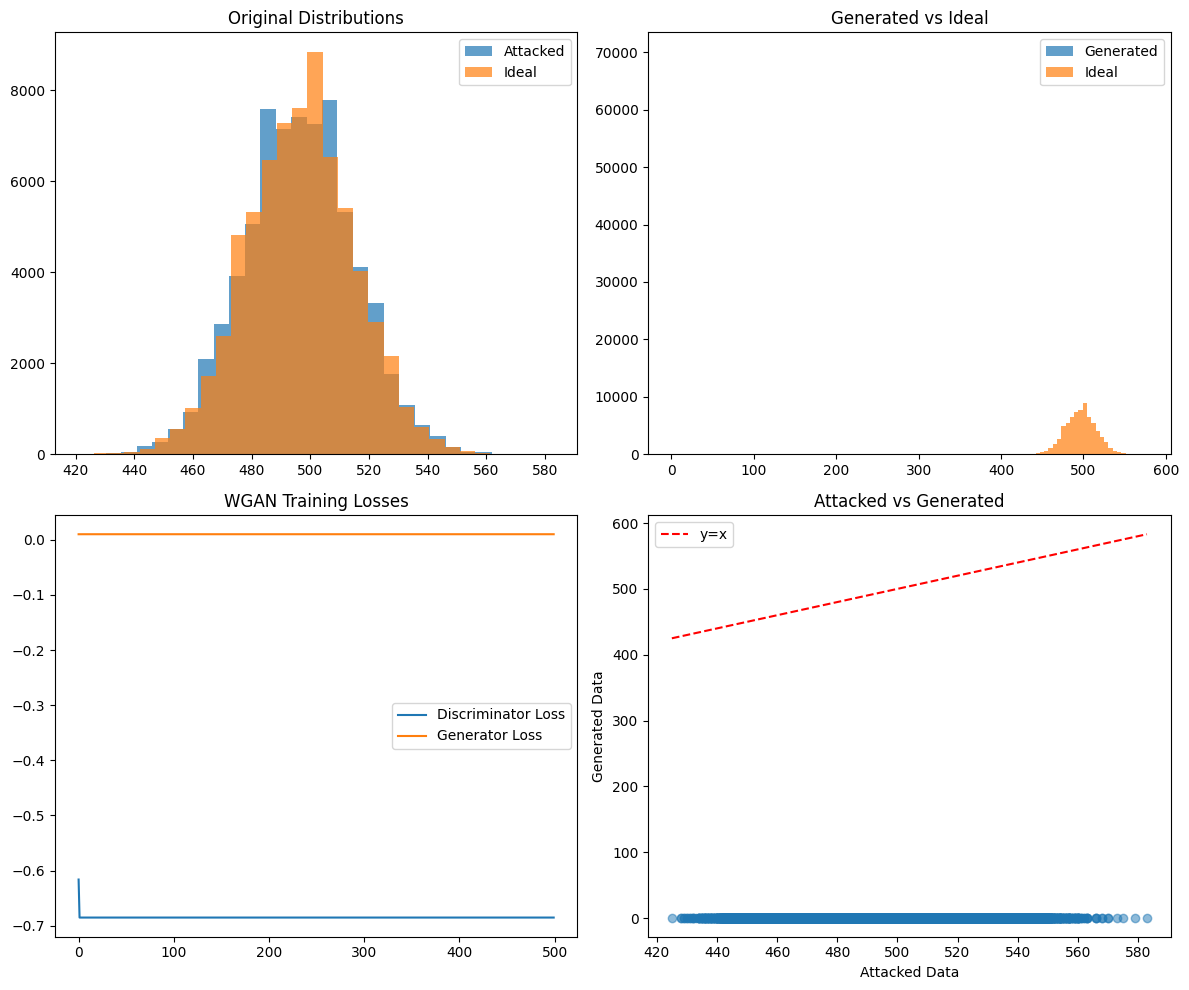

In [ ]:
print("Plotting results...")
plot_results(attacked_data, ideal_data, results['generated_data'], d_losses, g_losses)